In [255]:
from ortools.linear_solver import pywraplp
from ortools.init import pywrapinit
import numpy as np
from numpy import linalg as LA
import pandas as pd
from math import radians, cos, sin, asin, sqrt, dist
import geopy.distance
from scipy.stats import truncnorm
import rvo2
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.graph_objects as go
from ortools.sat.python import cp_model

In [256]:
#-----------------------------------EXTRACT THE DATA-----------------------------------

# users-melbcbd-generated.csv contains:
# •  Latitude-Longitude
# of the users in the Melbourne CBD area.
users_path = '..\\eua-dataset\\users\\'
U = pd.read_csv(users_path + 'users-test.csv')

# site-optus-melbCBD.csv contains:
# •  SiteID-Latitude-Longitude-Name-State-LicensingAreaID-PostCode-SitePrecision-Elevation-HCISL2
# of all Optus BS in Melbourne CBD area (edge-servers)
servers_path = '..\\eua-dataset\\edge-servers\\'
S = pd.read_csv(servers_path + 'serverstest_v2.csv')

In [257]:
#-----------------------------------VARIABLES-----------------------------------

U_si = [] #set of individuals allocated to server si

D = (-37.81952,144.95714099999998)  #Position Danger
D_rad = 0.3/111.139  # influence range of danger source D (radius) in km

U_per = np.full(len(U),0.2)  # perception range of individual uj in km
R = np.zeros((4), dtype=int) # R = [CPU, RAM, VRAM, bandwidth]

# User u has memory requirements = w (example for 8 users)
w1 = [1, 2, 1, 2]
w2 = [1, 2,	1, 2]
w3 = [5, 7,	6, 6]
w4 = [2, 3,	3, 4]
w5 = [5, 7,	6, 6]
w6 = [2, 3,	3, 4]
w7 = [1, 2, 1, 2]
w8 = [2, 3,	3, 4]
W = [w1, w2, w3, w4, w5, w6, w7, w8]   
  
# Each server has memory capacity c (example for 3 servers)
c1 = [4, 6, 6, 10]
c2 = [6, 17, 15, 16]
c3 = [8, 15, 11, 15]
C = [c1, c2, c3] 

T_1 =0 #Starting point of period
T_2 = 1 #Ending point of period
T = T_2-T_1 #Total interval time
#ti = np.random.randint(T_1,T_2) #random time step in the given period

lambd = 0.5 #severity of the stimulus event
#nej = np.random.uniform(0,1,len(U)) #emotional fluctuation of uj ---> nej ∈ (0, 1)
#se_j =np.random.uniform(0.05,0.1, len(U)) #individual sensitivity uj 
nej = np.full(len(U), 0.6)
se_j = np.full(len(U), 0.07)

#du_Dt=[]  #distance between danger and user (change with t ?????????????????????)


In [258]:
#---------------------------------- RVO Algorithm ----------------------------------
def rvoAlgorithm(U,DangerZone,D_radio,T_interval):
  pref_vel = 5/(111.1*3600)
  sim = rvo2.PyRVOSimulator(1,    #float timeStep
  1.5,    # float MAX neighborDist
                          len(U), # size_t maxNeighbors
                          1,    # float timeHorizon --->  tiempo de respuesta frente la presencia de otros agentes
                          2,      # float timeHorizonObst ---> tiempo de respuesta frente a presencia de obstaculos
                          1,      # float radius ---> of agents
                          pref_vel)      # float maxSpeed ---> of agents
                                  # tuple velocity=(0, 0)
  
  agents =[]
  for j in range(len(U)):
    user_latitude = U.iloc[j]['Latitude']
    user_longitude = U.iloc[j]['Longitude']
    agents.append(sim.addAgent((user_latitude,user_longitude)))

 
  circle_area = [DangerZone[0],DangerZone[1],D_radio]
  circle=[DangerZone[0],DangerZone[1],0.05/111.1]
  xc = circle[0] #x-co of circle (center) 
  xc_area=circle_area[0]
  yc = circle[1] #y-co of circle (center) 
  yc_area= circle_area[1]
  r=circle[2] 
  r_area=circle_area[2]
  t= np.arange(-np.pi,np.pi, 0.1) 
  x_circle= xc + r*np.sin(t) 
  x_circle_area = xc_area+r_area*np.sin(t)
  y_circle= yc + r*np.cos(t) 
  y_circle_area= yc_area + r_area*np.cos(t) 

  # Obstacles are also supported.
  o1 = sim.addObstacle([(xc+r,yc+r), (xc+r,yc-r), (xc-r,yc-r),(xc-r,yc+r)])
  sim.processObstacles()

  
  for a in range(len(agents)):
    #sim.setAgentPrefVelocity(agents[a], (-2,2))
    #sim.setAgentPrefVelocity(agents[a], (random.randint(-10, 10),random.randint(-10, 10)))
    sim.setAgentPrefVelocity(agents[a], (random.uniform(-pref_vel, pref_vel),random.uniform(-pref_vel, pref_vel)))

  #print('Simulation has %i agents and %i obstacle vertices in it.' %
        #(sim.getNumAgents(), sim.getNumObstacleVertices()))
  #print('Running simulation')
 
  positions_T=[]
  fig, ax = plt.subplots(figsize = (10,5))
  

  for step in range(T_interval):
    sim.doStep()

    positions = ['(%5.8f, %5.8f)' % sim.getAgentPosition(agent_no) for agent_no in (agents)]
    velocities = ['(%3.8f, %3.8f)' % sim.getAgentVelocity(agent_no)for agent_no in (agents)]
    
    #print('%s' % ( '  '.join(velocities)))
    #print('step=%2i  t=%.3f  %s' % (step, sim.getGlobalTime(), '  '.join(positions)))
    
    x_p=[]
    y_p=[]
    temp_T=[]

    colors = cm.rainbow(np.linspace(0, 1, len(positions)))
    
    for p in range(len(positions)):
      temp=positions[p]
      temp= temp.replace('(','')
      temp=temp.replace(')','')
      temp=temp.split(',')
      x_p.append(float(temp[0]))
      y_p.append(float(temp[1]))
      temp_T.append([float(temp[0]),float(temp[1])])

      if step==0:
        ax.scatter(float(temp[0]),float(temp[1]),color=colors[p],edgecolor='green', linewidth=2)

      if step==T_interval-1:
        ax.scatter(float(temp[0]),float(temp[1]),color=colors[p],edgecolor='red', linewidth=2)
      
      else:
        ax.scatter(float(temp[0]),float(temp[1]),edgecolors=colors[p],color='white',marker='o')

    positions_T.append(temp_T)
    
  ax.plot(x_circle,y_circle,color='red') 
  ax.plot(x_circle_area,y_circle_area,color='red',alpha=0.3) 
  ax.plot([xc+r,xc+r,xc-r,xc-r,xc+r],[yc+r,yc-r,yc-r,yc+r,yc+r],color='black',linewidth=2)
  ax.plot()
  ax.axis('equal')
  ax.set_title('Location')
  ax.ticklabel_format(useOffset=False)

  return positions_T
  #morado | azul | amarillo | rojo

In [259]:
#-----------------------------------COVERAGE OF EACH SERVER-----------------------------------

def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

for i in range(len(S)):
  server_latitude = S.iloc[i]['LATITUDE']
  server_longitude = S.iloc[i]['LONGITUDE']
  temp = []

  for j in range(len(U)):
    user_latitude = U.iloc[j]['Latitude']
    user_longitude = U.iloc[j]['Longitude']

    radius = 0.03 # in kilometer

    dist_geo = haversine(server_longitude, server_latitude, user_longitude, user_latitude)
    #dist_temp.append(dist_geo)

    if dist_geo <= radius:
        temp.append(1)
        
    else:
        temp.append(0)

  U_si.append(temp)


In [260]:
#---------------------------------- Update position users ----------------------------------

def du_dt_function(timeStep,positions):
    du_Dt=[] # Distance between danger and user
    for j in range(len(U)):
        user_latitude=positions[timeStep][j][0]
        user_longitude=positions[timeStep][j][1]
        user_coordinates = (user_latitude,user_longitude)
        dist_geoDanger = geopy.distance.geodesic(user_coordinates, D).km
        du_Dt.append(dist_geoDanger)
    return du_Dt

In [261]:
#-----------------------------------CRITICALITY MODEL-----------------------------------

def get_truncated_normal(mean, sd, low, upp):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

def criticality (time,du_Dt):
    #emj: emotional value
    em_t = np.zeros(len(U))
    for j in range(len(U)):
        if du_Dt[j] < (D_rad+U_per[j]):
            eq = ((time-T_1)/T) * (1-(du_Dt[j]/(D_rad+U_per[j])))*lambd* nej[j]
            em_t[j]=eq
        else:
            em_t[j]=0

    # scrj(t) = sej + emj (t) (subjective criticality)
    scr=np.zeros(len(U))
    for j in range(len(U)):
        scr[j]= (se_j[j]+em_t[j])

    ocr_j=np.zeros(len(U)) #ocr objective criticality of individual uj at time step t
    nDiv = 5 #number of partitions of the coverage area
    circles = D_rad/nDiv #radius of each circular partition
    covCircles = [] #Distance from the center
    ri = [0.5,0.4,0.3,0.2,0.1] # it should be lambda * ri ????

    for p in range(1,nDiv+1):
        covCircles.append(circles*p)

    for j in range(len(U)):
            if du_Dt[j]<covCircles[0]:
                ocr_j[j] = ri[0]

            elif du_Dt[j]<covCircles[1] and du_Dt[j]>=covCircles[0]:
                ocr_j[j]  =ri[1]

            elif du_Dt[j]<covCircles[2] and du_Dt[j]>=covCircles[1]:
                ocr_j[j]  = ri[2]

            elif du_Dt[j]<covCircles[3] and du_Dt[j]>=covCircles[2]:
                ocr_j[j] = ri[3]
            elif du_Dt[j]<covCircles[4] and du_Dt[j]>=covCircles[3]:
                ocr_j[j]  = ri[4]

            else:
                ocr_j[j]  = 0


    # Criticality
    #CRj = (L1 * scrj(t)) + (L2 * ocrj)

    mu=1
    sigma=0.05
    low=0.95
    up =1.05

    X = get_truncated_normal(mu, sigma, low, up)

    #L1 =X.rvs() # weight lambda 1
    L1 = 0.95
    L2 = 1 # weight lambda 2

    #Criticality
    CR = []

    for j in range(len(U)):
        cr = (L1*scr[j])+(L2*ocr_j[j])
        CR.append(cr)

    index_CR=sorted(range(len(CR)), key=lambda a: CR[a],reverse=True)

    return index_CR, CR

In [262]:
#-----------------------------------MIP SOLVER-----------------------------------
x_ij=np.zeros(shape=(len(S),len(U)))
def createModel_t(timeStep,live_positions):
    print(' -------------------------------------------------------------')
    print('Step:  ',timeStep)
    du_dt_temp = du_dt_function(timeStep,live_positions)
    index_CR_t,CR_t = criticality(timeStep,du_dt_temp)
    
    solver = pywraplp.Solver.CreateSolver('SCIP')

    #-----------------------------------SOLVER VARIABLES-----------------------------------
    # x_i,j = True if user u_j is allocated to edge server s_i
    # x_i,j = False otherwise
    x = {}
    for j in index_CR_t:
        for i in range(len(S)):
            x[i, j] = solver.BoolVar(f'c[{i}][{j}]')

    # y_i = True if Sum(xij) > 0, ∀i ∈ {1, . . . , m}
    # y_i = False otherwise
    y = {}
    for i in range(len(S)):
        y[i] = solver.BoolVar(f'c[{i}]')   

    #-----------------------------------CONSTRAINTS-----------------------------------

    # Capacity constraint
    for i in range(len(S)):
        for k in range(len(R)):
            solver.Add(
                solver.Sum([
                    x[i,j]*W[j][k] for j in index_CR_t
                ]) <= C[i][k]*y[i]
            )
        
    # Each user can be allocated just once
    for j in index_CR_t:
        solver.Add(
            solver.Sum([x[i, j] for i in range(len(S))]) <= 1
        )

    #Coverage
    for j in index_CR_t:
        for i in range(len(S)):
            if U_si[i][j] == 0:
                solver.Add(
                x[i, j]==0
                )
     
    #-----------------------------------OBJECTIVE FUNCTION-----------------------------------
    # Maximize the number of allocated users
    objective = solver.Objective()
    for j in index_CR_t:
        for i in range(len(S)):
            objective.SetCoefficient(x[i, j],CR_t[j])
    objective.SetMaximization()

    #-----------------------------------CALL THE SOLVER-----------------------------------
    status = solver.Solve()

    #-----------------------------------DISPLAY THE SOLUTION-----------------------------------

    if status == pywraplp.Solver.OPTIMAL:
        print('Solution:')
        print('Objective value x=', objective.Value())
        for j in index_CR_t:
            for i in range(len(S)):
                #print("i: ",i,"j: ",j," value: ",x[i,j].solution_value())
                if int(x[i,j].solution_value()) == 1:
                    x_ij[i][j]=1
                    print(f'User {j} has been allocated on server {i}')
    else:
        print('The problem does not have an optimal solution.')    
    
    #-----------------------------------CP SOLVER-----------------------------------
    print('--------------------------CP Solver--------------------------------------')        
    possible_x = np.empty(shape=(len(S), len(U)))
    model = cp_model.CpModel()
    for j in index_CR_t:
        for i in range(len(S)): 
            if x[i,j].solution_value()== 1:
                possible_x[i][j]=1
    
    x_cp = {}
    for j in range(len(CR_t)):
        for i in range(len(S)):
            x_cp[i, j] = model.NewBoolVar(f'c[{i}][{j}]')
    
    y_cp = {}
    for i in range(len(S)):
        y_cp[i] = model.NewBoolVar(f'c[{i}]')

    # Capacity constraint
    for i in range(len(S)):
        for k in range(len(R)):
            model.Add(
                sum([
                    x_cp[i,j] * W[j][k] for j in range(len(CR_t))
                ]) <= C[i][k]*y_cp[i]
            )
    
    #Each user can be allocated just once
    for j in range(len(CR_t)):
        model.Add(
            sum([
                x_cp[i, j] for i in range(len(S))
            ]) <= 1
        )
    
    #Coverage
    for j in range(len(CR_t)):
        for i in range(len(S)):
            if U_si[i][j] == 0:
             model.Add(
                x_cp[i, j]==0
             )
    
    solver_cp = cp_model.CpSolver()

    model.Maximize(sum([x_cp[i,j] for i in range(len(S))for j in range(len(CR_t))]))

    solver_cp.Solve(model)
    # Hint (speed up solving)
    for j in range(len(CR_t)):
        for i in range(len(S)):
            model.AddHint(x_cp[i,j], int(possible_x[i][j]))
    
    # Constraint previous objective
    model.Add(
        sum([
            x_cp[i, j] for i in range(len(S)) for j in range(len(CR_t))
        ]) == round(np.sum(possible_x))
    )

    max_users = np.sum(possible_x)
    # Minimize the number of servers used
    objective_min = []
    for i in range(len(S)):
          objective_min.append(y_cp[i])
    model.Minimize(sum(objective_min))
    #model.Minimize(sum([y[j] for j in range(len(CR_t))]))
    solver_cp.Solve(model)

    #---------------------------------- CALL THE SOLVER ----------------------------------
    status_cp = solver_cp.Solve(model)

    #---------------------------------- DISPLAY THE SOLUTION ----------------------------------

    if status_cp == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        print('Solution:')
        print(f'Objective value: {max_users} users, have been allocated to {solver_cp.ObjectiveValue()} servers and criticality {objective.Value()}\n')
        for j in range(len(U)):
            for i in range(len(S)):
                if int(solver_cp.Value(x_cp[i,j]))== 1:
                    print(f'x[{i},{j}]: ',f'User {j} has been allocated on server {i}')
    else:
        print('The problem does not have an optimal solution.')


 -------------------------------------------------------------
Step:   0
Solution:
Objective value x= 0.4655
User 0 has been allocated on server 0
User 1 has been allocated on server 0
User 2 has been allocated on server 2
User 3 has been allocated on server 1
User 5 has been allocated on server 1
User 6 has been allocated on server 2
User 7 has been allocated on server 2
--------------------------CP Solver--------------------------------------
The problem does not have an optimal solution.


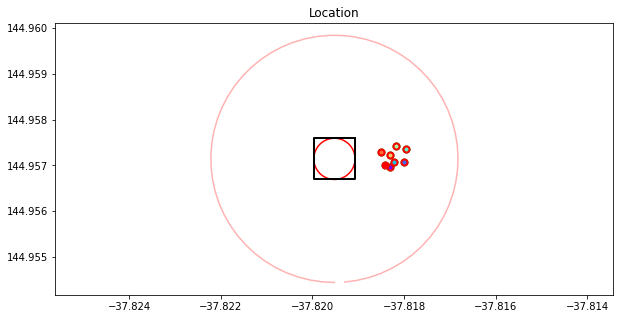

In [263]:

live_positions = rvoAlgorithm(U,D,D_rad,T)
for tt in range(T):
    createModel_t(tt,live_positions)

In [264]:
type(x_ij[0][1])

numpy.float64